In [371]:
import numpy as np
from scipy.special import expn
import matplotlib.pyplot as plt

In [372]:
width = 50
nx = 100
nang = 12
mfp = 5
sigma = mfp / width
dx = width / nx

In [373]:
@np.vectorize
def step(psi_minus, mu, dx=dx, sigma=sigma, s=0):
    mux = mu / dx
    
    num = s + mux * psi_minus
    den = mux + sigma
    
    psi_plus = abs(num / den)
    
    psi_avg = psi_plus
    
    return psi_avg, psi_plus

In [374]:
@np.vectorize
def diamond_difference(psi_minus, mu, dx=dx, sigma=sigma, s=0):
    mux = mu / dx
    hsig = sigma / 2
    
    psi_plus = s + (mux - hsig) * psi_minus
    psi_plus /= mux + sigma / 2
    psi_plus = abs(psi_plus)
    
    psi_avg = (psi_minus + psi_plus) / 2
    
    return psi_avg, psi_plus

In [375]:
@np.vectorize
def weighted_diamond_difference(psi_minus, mu, dx=dx, sigma=sigma, s=0, alpha=0.8):
    mux = mu / dx
    
    psi_plus = s + (mux - (1 - alpha) * sigma) * psi_minus
    psi_plus /= (mux) + (alpha * sigma)
    psi_plus = abs(psi_plus)
    
    psi_avg = (1 - alpha) * psi_minus + alpha * psi_plus
    
    return psi_avg, psi_plus

In [376]:
function = {
    'step': step,
    'diamond difference': diamond_difference,
    'weighted diamond difference': weighted_diamond_difference
}

In [377]:
sigma

0.1

In [378]:
def set_quadrature(nang):
    wt = []
    mu = []

    if(nang==2):
        wt.append(1.)

        mu.append(.5773502691)

    elif(nang==4):
        wt.append(.6521451549)
        wt.append(.3478548451)

        mu.append(.3399810435)
        mu.append(.8611363115)

    elif(nang==8):
        wt.append(.3626837834)
        wt.append(.3137066459)
        wt.append(.2223810344)
        wt.append(.1012285363)

        mu.append(.1834346424)
        mu.append(.5255324099)
        mu.append(.7966664774)
        mu.append(.9602898564)

    elif(nang==12):
        wt.append(0.2491470458)
        wt.append(0.2334925365)
        wt.append(0.2031674267)
        wt.append(0.1600783286)
        wt.append(0.1069393260)
        wt.append(0.0471753364)

        mu.append(0.1252334085)
        mu.append(0.3678314989)
        mu.append(0.5873179542)
        mu.append(0.7699026741)
        mu.append(0.9041172563)
        mu.append(0.9815606342)

    wt = [0.5*w for w in wt]
    
    return np.array(wt), np.array(mu)

In [379]:
wts, mus = set_quadrature(12)
for m, w in zip(wts, mus):
    print(f"{m:0.3f}\t\t{w:0.3f}")

0.125		0.125
0.117		0.368
0.102		0.587
0.080		0.770
0.053		0.904
0.024		0.982


In [380]:
left = np.zeros((nang, nx))
right = np.zeros((nang, nx))
average = np.zeros((nang, nx))
scalar = np.zeros(nx)
left[:,0] = np.ones_like(left[:,0])

In [381]:
def scalar(avg):
    num_angles = avg.shape[0]

    wts, mus = set_quadrature(num_angles)

    return avg.T @ np.concatenate([wts, wts])

In [382]:
def conv_test(old, new):
    if np.max(new) == 0.0:
        return 1.0
    else:
        e = np.abs(new - old) / new
        err = np.max(e)
        return err

In [383]:
def make_flux(nx, nang, func='step', eps=1e-5):
    width = 50
    mfp = 5
    sigma = mfp / width
    dx = width / nx
    f = function[func]
    
    left = np.zeros((nang, nx))
    right = np.zeros((nang, nx))
    avg = np.zeros((nang, nx))
    left[:,0] = np.ones_like(left[:,0])
    
    wts, mus = set_quadrature(nang)

    old = np.ones(left.shape[1])
    
    conv = [1]
    eps = 0.000001
    
    while conv[-1] > eps:
        for x in range(nx):
            avg[:int(nang/2), x], right[:int(nang/2), x] = f(left[:int(nang/2), x], mus)
            if x+1 < left.shape[1]:
                left[:, x+1] = right[:, x]
        for x in range(nx)[::-1]:
            avg[int(nang/2):, x], left[int(nang/2):, x] = f(right[int(nang/2):, x], -mus)
            if x > 0:
                right[:, x-1] = left[:, x]

        s = scalar(avg)
        conv.append(conv_test(old, s))

        old = np.copy(s)
    
    return left, right, conv

In [384]:
l, r, c = make_flux(100, 2)

In [391]:
l[:, 0]

array([1., 0.])

In [386]:
r[:, -1]

array([0.00024713, 0.        ])

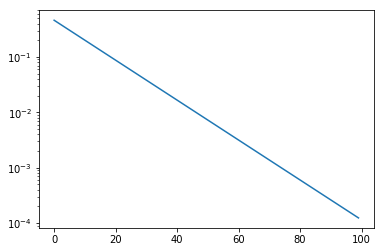

In [387]:
plt.plot(scalar(r))
plt.yscale('log')

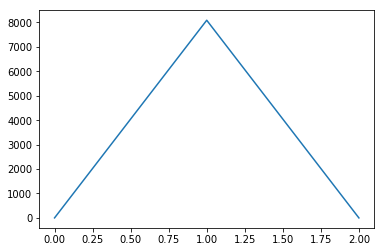

In [388]:
plt.plot(c)

In [389]:
c

[1, 8091.852037496592, 0.0]

In [390]:
np.exp(-5)

0.006737946999085467